In [1]:
from src.data_loader import load_full_data, load_filtered_data
from src.features import get_features_and_target, get_onehot_midi_sequences
from src.models import train_linear, train_ridge, train_lasso
from src.utils import split_data
from src.evaluation import evaluate_model, print_coefficients, cross_validate_model, bootstrap_prediction_intervals, kfold_bootstrap_ci_analysis
import pandas as pd

## Linear Regression (authentic cadence, notes only)

In [2]:
# --- Load truncated stems of authentic cadence ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath, prefix="HC")
X, y = get_features_and_target(df, feature_steps=range(1,7), target_col='step7')

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train model ---
model = train_linear(x_train, y_train)

# --- Evaluate model ---
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)

# --- Print coefficients ---
print_coefficients(model)

# --- 5-fold cross-validation ---
cross_validate_model(X, y, k=5)

ci_df = kfold_bootstrap_ci_analysis(
    model_type="linear",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 7.9111
Training set r-squared score: 0.2862
Validation set mean squared error: 3.3977
Validation set r-squared score: -11.6748
Testing set mean squared error: 12.6978
Testing set r-squared score: -7.5178

Learned coefficients (weights for each step):
Step 1: -0.0223
Step 2: 0.0030
Step 3: -0.0415
Step 4: -0.5084
Step 5: 0.0757
Step 6: 0.3241

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 20.7250, R² = -1.3075
Fold 2: MSE = 27.5917, R² = -0.7690
Fold 3: MSE = 12.5057, R² = -0.6966
Fold 4: MSE = 16.2414, R² = -0.7736
Fold 5: MSE = 13.8226, R² = -3.7817

***** Average over 5 folds *****
Average MSE: 18.1773
Average R²: -1.4657

Overall coverage across all folds: 44.44% within 95% CI


## Linear Regression (authentic cadence, notes and key)

In [4]:
from src.data_loader import load_filtered_data
from src.features import get_features_and_target
from src.models import train_linear
from src.utils import split_data
from src.evaluation import evaluate_model, print_coefficients, cross_validate_model, kfold_bootstrap_ci_analysis

# --- Load and preprocess ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath, prefix="HC")

# Add numeric features for key and dominant chord
KEY_TO_MIDI = {
    'C': 60, 'C_sharp': 61, 'D_flat': 61, 'D': 62, 'E_flat': 63, 'E': 64,
    'F': 65, 'F_sharp': 66, 'G': 67, 'A_flat': 68, 'A': 69, 'B_flat': 70, 'B': 71
}
df['key_midi'] = df['key'].map(KEY_TO_MIDI)

# --- Feature extraction ---
X, y = get_features_and_target(
    df,
    feature_steps=range(1, 7),
    extra_feature_cols=['key_midi'],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_linear(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="linear",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 7.5499
Training set r-squared score: 0.1767
Validation set mean squared error: 12.2592
Validation set r-squared score: 0.0417
Testing set mean squared error: 6.6470
Testing set r-squared score: 0.1006

Learned coefficients (weights for each step):
Step 1: 0.0372
Step 2: 0.0538
Step 3: -0.1389
Step 4: -0.2324
Step 5: 0.0837
Step 6: 0.1886
Step 7: -0.0783

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 16.7807, R² = -0.8683
Fold 2: MSE = 26.5663, R² = -0.7033
Fold 3: MSE = 11.5641, R² = -0.5689
Fold 4: MSE = 15.7292, R² = -0.7176
Fold 5: MSE = 8.1048, R² = -1.8037

***** Average over 5 folds *****
Average MSE: 15.7490
Average R²: -0.9324

Overall coverage across all folds: 55.56% within 95% CI


## Linear Regression (authentic cadence, notes and key and V chord)

In [7]:
# --- Load and preprocess ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath, prefix="HC")

# Add numeric features for key and dominant chord
KEY_TO_MIDI = {
    'C': 60, 'C_sharp': 61, 'D_flat': 61, 'D': 62, 'E_flat': 63, 'E': 64,
    'F': 65, 'F_sharp': 66, 'G': 67, 'A_flat': 68, 'A': 69, 'B_flat': 70, 'B': 71
}
df['key_midi'] = df['key'].map(KEY_TO_MIDI)
df['V_midi'] = df['V_chord_root']

# --- Feature extraction ---
X, y = get_features_and_target(
    df,
    feature_steps=range(1, 7),
    extra_feature_cols=['key_midi', 'V_midi'],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_linear(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="linear",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 7.1299
Training set r-squared score: 0.2291
Validation set mean squared error: 19.1188
Validation set r-squared score: -0.9083
Testing set mean squared error: 7.4278
Testing set r-squared score: -3.4074

Learned coefficients (weights for each step):
Step 1: 0.0373
Step 2: -0.0875
Step 3: -0.0415
Step 4: -0.2224
Step 5: 0.0247
Step 6: 0.2548
Step 7: -0.0097
Step 8: 0.1859

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 10.0654, R² = -0.1207
Fold 2: MSE = 20.0115, R² = -0.2830
Fold 3: MSE = 8.2748, R² = -0.1226
Fold 4: MSE = 17.5877, R² = -0.9206
Fold 5: MSE = 7.9229, R² = -1.7408

***** Average over 5 folds *****
Average MSE: 12.7725
Average R²: -0.6375

Overall coverage across all folds: 64.44% within 95% CI


# Linear Regression (authentic cadences, notes + contour features)

***** Evaluation Results *****
Training set mean squared error: 4.5319
Training set r-squared score: 0.4690
Validation set mean squared error: 10.9800
Validation set r-squared score: -0.0555
Testing set mean squared error: 10.8712
Testing set r-squared score: -0.1649

Learned coefficients (weights for each step):
Step 1: -0.2120
Step 2: -0.3618
Step 3: 0.1356
Step 4: 0.0023
Step 5: 0.3617
Step 6: 0.8469
Step 7: 3.5075
Step 8: -2.0884
Step 9: 3.7540
Step 10: -3.0522
Step 11: -0.3051
Step 12: -0.3127
Step 13: -0.2864
Step 14: -0.2497

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 4.0544, R² = 0.5486
Fold 2: MSE = 21.3119, R² = -0.3664
Fold 3: MSE = 10.0053, R² = -0.3574
Fold 4: MSE = 23.4094, R² = -1.5563
Fold 5: MSE = 18.7252, R² = -5.4776

***** Average over 5 folds *****
Average MSE: 15.5012
Average R²: -1.4418

Overall coverage across all folds: 86.67% within 95% CI


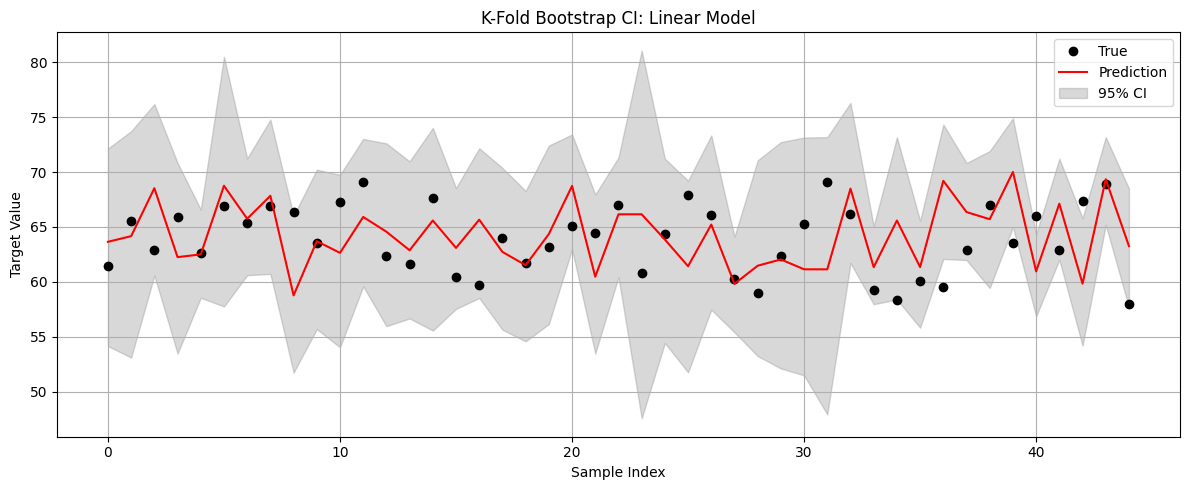

In [18]:
# --- Intervals & Contour ---
for i in range(1, 6):
    df[f'intv{i}'] = df[f'step{i+1}'] - df[f'step{i}']
    df[f'is_rising{i}'] = (df[f'step{i+1}'] > df[f'step{i}']).astype(int)

# --- Tonal Distance ---
df['step6_to_key'] = (df['step6'] - df['key_midi']) % 12
df['step6_to_V'] = (df['step6'] - df['V_midi']) % 12

# --- Pitch Classes ---
for i in range(1, 7):
    df[f'step{i}_pc'] = df[f'step{i}'] % 12

X, y = get_features_and_target(
    df,
    feature_steps=[],  
    extra_feature_cols=[
        'intv1', 'intv2', 'intv3', 'intv4', 'intv5',
        'is_rising1', 'is_rising2', 'is_rising3', 'is_rising4', 'is_rising5',
        'step6_to_key', 'step6_to_V',
        'key_midi', 'V_midi'
    ],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_linear(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="linear",
    X=X,
    y=y,
    k=5,
    n_bootstraps=10000,
    alpha=0.05,
    plot=True
)

## Linear Regression (all cadences, notes only)

In [3]:
# --- Load truncated stems of all cadences ---
filepath = 'data/truncated_stems.csv'
df = load_full_data(filepath)
X, y = get_features_and_target(df, feature_steps=range(1,7), target_col='step7')

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train model ---
model = train_linear(x_train, y_train)

# --- Evaluate model ---
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)

# --- Print coefficients ---
print_coefficients(model)

# --- 5-fold cross-validation ---
cross_validate_model(X, y, k=5)

ci_df = kfold_bootstrap_ci_analysis(
    model_type="linear",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 5.6634
Training set r-squared score: 0.2112
Validation set mean squared error: 10.2998
Validation set r-squared score: -0.2790
Testing set mean squared error: 8.6078
Testing set r-squared score: 0.2082

Learned coefficients (weights for each step):
Step 1: 0.0133
Step 2: -0.0184
Step 3: -0.1234
Step 4: -0.2153
Step 5: 0.0817
Step 6: 0.2319

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 15.5600, R² = -0.3990
Fold 2: MSE = 12.7756, R² = -0.7904
Fold 3: MSE = 12.8228, R² = -1.2000
Fold 4: MSE = 17.9676, R² = -2.3728
Fold 5: MSE = 8.2513, R² = -0.0406

***** Average over 5 folds *****
Average MSE: 13.4755
Average R²: -0.9605

Overall coverage across all folds: 40.00% within 95% CI


## Ridge Regression (authentic cadence, notes only)

In [4]:
# --- Load truncated stems of authentic cadence ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath)
X, y = get_features_and_target(df, feature_steps=range(1,7), target_col='step7')

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train model ---
model = train_ridge(x_train, y_train, alpha=1.0)

# --- Evaluate model ---
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)

# --- Print coefficients ---
print_coefficients(model)

# --- 5-fold cross-validation ---
cross_validate_model(X, y, k=5, model_type="ridge", alpha=1.0)

ci_df = kfold_bootstrap_ci_analysis(
    model_type="ridge",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 7.6793
Training set r-squared score: 0.2272
Validation set mean squared error: 6.2976
Validation set r-squared score: -0.1631
Testing set mean squared error: 8.7092
Testing set r-squared score: -0.5411

Learned coefficients (weights for each step):
Step 1: 0.0072
Step 2: -0.0285
Step 3: -0.0547
Step 4: -0.3580
Step 5: 0.0635
Step 6: 0.2785

***** 5-Fold Cross-Validation (Ridge) Results *****
Fold 1: MSE = 20.7225, R² = -1.3072
Fold 2: MSE = 27.6016, R² = -0.7696
Fold 3: MSE = 12.5043, R² = -0.6965
Fold 4: MSE = 16.2126, R² = -0.7704
Fold 5: MSE = 13.8129, R² = -3.7783

***** Average over 5 folds *****
Average MSE: 18.1708
Average R²: -1.4644

Overall coverage across all folds: 48.89% within 95% CI


## Ridge Regression (all cadences, notes only)

In [5]:
# --- Load truncated stems of all cadences ---
filepath = 'data/truncated_stems.csv'
df = load_full_data(filepath)
X, y = get_features_and_target(df, feature_steps=range(1,7), target_col='step7')

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train model ---
model = train_ridge(x_train, y_train, alpha=1.0)

# --- Evaluate model ---
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)

# --- Print coefficients ---
print_coefficients(model)

# --- 5-fold cross-validation ---
cross_validate_model(X, y, k=5, model_type="ridge", alpha=1.0)

ci_df = kfold_bootstrap_ci_analysis(
    model_type="ridge",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 6.0329
Training set r-squared score: 0.2457
Validation set mean squared error: 11.1367
Validation set r-squared score: -0.2184
Testing set mean squared error: 6.1125
Testing set r-squared score: -1.8013

Learned coefficients (weights for each step):
Step 1: -0.0146
Step 2: -0.0244
Step 3: -0.1317
Step 4: -0.1984
Step 5: 0.0409
Step 6: 0.3217

***** 5-Fold Cross-Validation (Ridge) Results *****
Fold 1: MSE = 15.5606, R² = -0.3990
Fold 2: MSE = 12.7722, R² = -0.7899
Fold 3: MSE = 12.8167, R² = -1.1989
Fold 4: MSE = 17.9668, R² = -2.3726
Fold 5: MSE = 8.2545, R² = -0.0410

***** Average over 5 folds *****
Average MSE: 13.4741
Average R²: -0.9603

Overall coverage across all folds: 37.78% within 95% CI


## Lasso Regression (authentic cadence, notes only)

In [6]:
# --- Load truncated stems of all cadences ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath)
X, y = get_features_and_target(df, feature_steps=range(1,7), target_col='step7')

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train model ---
model = train_lasso(x_train, y_train, alpha=1.0)

# --- Evaluate model ---
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)

# --- Print coefficients ---
print_coefficients(model)

# --- 5-fold cross-validation ---
cross_validate_model(X, y, k=5, model_type="lasso", alpha=1.0)

ci_df = kfold_bootstrap_ci_analysis(
    model_type="lasso",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 16.8826
Training set r-squared score: -0.6518
Validation set mean squared error: 8.8756
Validation set r-squared score: -4.2763
Testing set mean squared error: 14.6054
Testing set r-squared score: -0.4969

Learned coefficients (weights for each step):
Step 1: 0.0000
Step 2: 0.0000
Step 3: 0.0317
Step 4: -0.0000
Step 5: 0.4309
Step 6: 0.5472

***** 5-Fold Cross-Validation (Lasso) Results *****
Fold 1: MSE = 19.6460, R² = -1.1874
Fold 2: MSE = 27.7218, R² = -0.7773
Fold 3: MSE = 12.8603, R² = -0.7447
Fold 4: MSE = 13.5627, R² = -0.4810
Fold 5: MSE = 13.3910, R² = -3.6324

***** Average over 5 folds *****
Average MSE: 17.4364
Average R²: -1.3646

Overall coverage across all folds: 40.00% within 95% CI


## Lasso Regression (all cadences, notes only)

In [3]:
# --- Load truncated stems of all cadences ---
filepath = 'data/truncated_stems.csv'
df = load_full_data(filepath)
X, y = get_features_and_target(df, feature_steps=range(1,7), target_col='step7')

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train model ---
model = train_lasso(x_train, y_train, alpha=1.0)

# --- Evaluate model ---
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)

# --- Print coefficients ---
print_coefficients(model)

# --- 5-fold cross-validation ---
cross_validate_model(X, y, k=5, model_type="lasso", alpha=1.0)

ci_df = kfold_bootstrap_ci_analysis(
    model_type="lasso",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 12.5015
Training set r-squared score: -0.6594
Validation set mean squared error: 6.7268
Validation set r-squared score: 0.1710
Testing set mean squared error: 9.4265
Testing set r-squared score: -0.2301

Learned coefficients (weights for each step):
Step 1: 0.0256
Step 2: 0.0018
Step 3: 0.0000
Step 4: 0.0471
Step 5: 0.3758
Step 6: 0.5624

***** 5-Fold Cross-Validation (Lasso) Results *****
Fold 1: MSE = 15.2465, R² = -0.3708
Fold 2: MSE = 12.5669, R² = -0.7612
Fold 3: MSE = 11.0464, R² = -0.8952
Fold 4: MSE = 17.0015, R² = -2.1914
Fold 5: MSE = 8.0766, R² = -0.0186

***** Average over 5 folds *****
Average MSE: 12.7876
Average R²: -0.8474

Overall coverage across all folds: 31.11% within 95% CI


# Sequential Model

In [11]:
X, y, (min_midi, max_midi) = get_onehot_midi_sequences(filepath, feature_steps=range(1,7), target_col='step7')
X.shape
print(f"MIDI One-Hot Vector Range: ({min_midi}, {max_midi})")

MIDI One-Hot Vector Range: (51, 78)
